In [1]:
import json
import warnings
import random
import math

warnings.filterwarnings("ignore")

import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from matplotlib.colors import LogNorm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15, 8)
legend_fontsize = 16

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = (
                clone.n_rows,
                clone.n_cols,
                clone.n_win,
            )
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = "".join(
                ["%s" % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)]
            )
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i : i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i, j : j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(
                        np.array(
                            [
                                self.board[i + k, j + k] == cur_p
                                for k in range(self.n_win)
                            ]
                        )
                    ):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(
                        np.array(
                            [
                                self.board[i + k, j - k] == cur_p
                                for k in range(self.n_win)
                            ]
                        )
                    ):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print("----" * (self.n_cols) + "-")
            out = "| "
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = "x"
                if self.board[i, j] == -1:
                    token = "o"
                if self.board[i, j] == 0:
                    token = " "
                out += token + " | "
            print(out)
        print("----" * (self.n_cols) + "-")

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    """Рисуем доску с оценками из стратегии pi"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + 0.01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap("Accent", 10), vmin=-1, vmax=1)
    if showtext:
        for i, a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text(
                    a[1],
                    a[0],
                    "%.3f" % pi.Q[s][i],
                    fontsize=fontq,
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="w",
                )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(
                    j,
                    i,
                    "O",
                    fontsize=fontx,
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="w",
                )
            if env.board[i, j] == 1:
                ax.text(
                    j,
                    i,
                    "X",
                    fontsize=fontx,
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="w",
                )
    #     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()


def get_and_print_move(
    env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60
):
    """Делаем ход, рисуем доску"""
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i, a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(
    env,
    pi1,
    pi2,
    random_crosses=False,
    random_naughts=True,
    verbose=True,
    fontq=20,
    fontx=60,
):
    """Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры"""
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(
                env,
                pi1,
                s,
                actions,
                random=random_crosses,
                verbose=verbose,
                fontq=fontq,
                fontx=fontx,
            )
        else:
            a = get_and_print_move(
                env,
                pi2,
                s,
                actions,
                random=random_naughts,
                verbose=verbose,
                fontq=fontq,
                fontx=fontx,
            )
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
def Q_learning_episode(env, pi_1, pi_2, alpha=0.009, epsilon=0.1, gamma=1.0):
    env.reset()
    board_hash, emptySpaces, curTurn = env.getState()
    reward = 0
    done = False
    pi_1_prev_board = None
    pi_1_prev_a = None
    pi_2_prev_board = None
    pi_2_prev_a = None
    while not done:
        if curTurn == 1:  # Ходят крестики
            if (
                board_hash in pi_1.Q and np.random.random() > epsilon
            ):  # знакомое состояние + идем по стратегии, а не exploration
                idx = np.argmax(pi_1.Q[board_hash])
            else:
                idx = np.random.randint(
                    len(emptySpaces)
                )  # играем случайно (или незнакомое состояние, или exploration)
                if (
                    board_hash not in pi_1.Q
                ):  # Если состояние не знакомое - добавляем его
                    pi_1.Q[board_hash] = np.zeros(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
            # Теперь мы получили следующее состояние для обучения стратегии ноликов
            if pi_2_prev_board is not None:
                gamma_term = (
                    gamma * np.max(pi_2.Q[board_hash_prime])
                    if board_hash_prime in pi_2.Q
                    else 0
                )
                pi_2.Q[pi_2_prev_board][pi_2_prev_a] = pi_2.Q[pi_2_prev_board][
                    pi_2_prev_a
                ] + alpha * (
                    -reward + gamma_term - pi_2.Q[pi_2_prev_board][pi_2_prev_a]
                )
            # Если крестики победили этим ходом, то нужно запомнить, что предыдущее состояние для нас было удачное
            if reward == 1:
                pi_1.Q[board_hash][idx] = reward
            pi_1_prev_board = board_hash
            pi_1_prev_a = idx
        elif curTurn == -1:  # Ходят нолики
            if board_hash in pi_2.Q and np.random.random() > epsilon:
                idx = np.argmax(pi_2.Q[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
                if board_hash not in pi_2.Q:
                    pi_2.Q[board_hash] = np.zeros(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
            # Теперь мы получили следующее состояние для обучения стратегии крестиков
            if pi_1_prev_board is not None:
                gamma_term = (
                    gamma * np.max(pi_1.Q[board_hash_prime])
                    if board_hash_prime in pi_1.Q
                    else 0
                )
                pi_1.Q[pi_1_prev_board][pi_1_prev_a] = pi_1.Q[pi_1_prev_board][
                    pi_1_prev_a
                ] + alpha * (reward + gamma_term - pi_1.Q[pi_1_prev_board][pi_1_prev_a])
            # Если мы победили этим ходом, то нужно запомнить, что предыдущее состояние для нас было удачное
            if reward == -1:
                pi_2.Q[board_hash][idx] = -reward
            pi_2_prev_board = board_hash
            pi_2_prev_a = idx
        else:
            raise Exception("There is only 2 players!")

        board_hash, emptySpaces, curTurn = (
            board_hash_prime,
            emptySpaces_prime,
            curTurn_prime,
        )

In [7]:
def play_test_game(env, pi_1=None, pi_2=None):
    env.reset()
    board_hash, emptySpaces, curTurn = env.getState()
    reward = 0
    done = False
    while not done:
        if curTurn == 1:  # Ходят крестики
            if pi_1 is not None and board_hash in pi_1.Q:
                idx = np.argmax(pi_1.Q[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
        elif curTurn == -1:  # Ходят нолики
            if pi_2 is not None and board_hash in pi_2.Q:
                idx = np.argmax(pi_2.Q[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
        else:
            raise Exception("There is only 2 players!")

        board_hash, emptySpaces, curTurn = (
            board_hash_prime,
            emptySpaces_prime,
            curTurn_prime,
        )
    return reward


def test_policy(env, pi_1=None, pi_2=None, num_episodes=500):
    total_reward = 0
    for _ in range(num_episodes):
        total_reward += play_test_game(env, pi_1=pi_1, pi_2=pi_2)
    return total_reward / num_episodes


def plot_results(result):
    plt.figure(figsize=(10, 5))
    plt.xlabel("Number of episodes")
    plt.ylabel("Average reward")
    plt.plot(result[0], result[1], label="Crosses")
    plt.plot(result[0], result[2], label="Noughts")
    plt.legend(loc="upper left")

In [8]:
class Strategy:
    def __init__(self):
        self.Q = dict()

    def getActionGreedy(self, s, na):
        if s in self.Q:
            return np.argmax(self.Q[s])
        else:
            return np.random.randint(na)

In [9]:
pi_1_3_3 = Strategy()
pi_2_3_3 = Strategy()

env = TicTacToe(3, 3, 3)
total_episodes = 200000
test_episodes = 1000
idxs = []
crosses = []
noughts = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning_episode(env, pi_1_3_3, pi_2_3_3, epsilon=0.3)
    if i % test_episodes == 0:
        cross = test_policy(env, pi_1=pi_1_3_3, pi_2=None, num_episodes=500)
        nought = -test_policy(env, pi_1=None, pi_2=pi_2_3_3, num_episodes=500)
        idxs.append(i)
        crosses.append(cross)
        noughts.append(nought)
idxs = np.array(idxs)
crosses = np.array(crosses)
noughts = np.array(noughts)

result = np.vstack((idxs, crosses, noughts))

100%|██████████| 200000/200000 [04:45<00:00, 699.69it/s] 


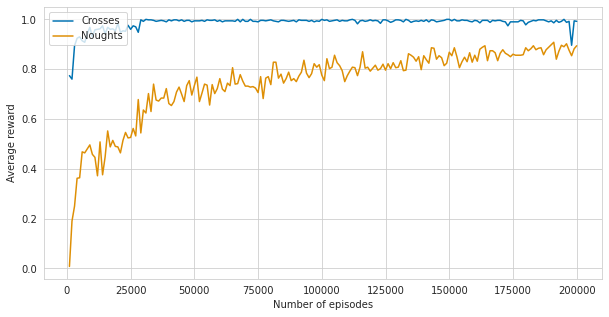

In [10]:
plot_results(result)
plt.show()

In [11]:
print(f"Average Crosses reward against random Noughts: {result[1][-1]:0.4f}")
print(f"Average Noughts reward against random Crosses: {result[2][-1]:0.4f}")

Average Crosses reward against random Noughts: 0.9920
Average Noughts reward against random Crosses: 0.8940


### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

#### 4x4

In [9]:
pi_1 = Strategy()
pi_2 = Strategy()

env = TicTacToe(4, 4, 4)
total_episodes = 1000000
test_episodes = 1000
idxs = []
crosses = []
noughts = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning_episode(env, pi_1, pi_2, epsilon=0.3, alpha=0.009)
    if i % test_episodes == 0:
        cross = test_policy(env, pi_1=pi_1, pi_2=None, num_episodes=500)
        nought = -test_policy(env, pi_1=None, pi_2=pi_2, num_episodes=500)
        idxs.append(i)
        crosses.append(cross)
        noughts.append(nought)
idxs = np.array(idxs)
crosses = np.array(crosses)
noughts = np.array(noughts)

result = np.vstack((idxs, crosses, noughts))

100%|██████████| 1000000/1000000 [28:54<00:00, 576.50it/s]


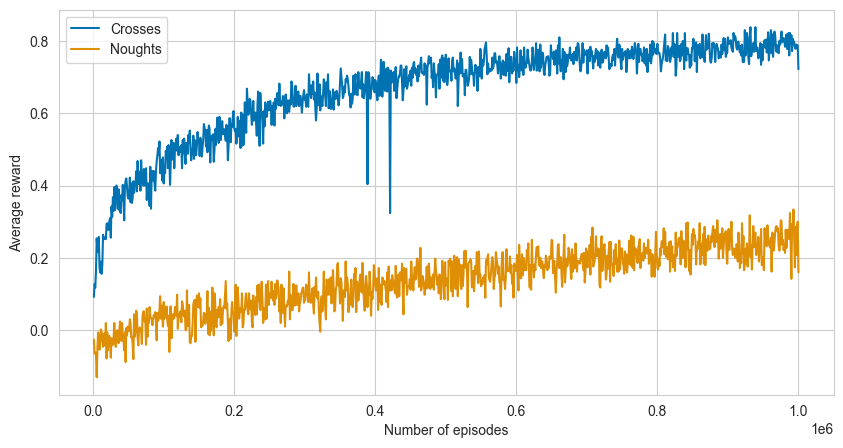

In [10]:
plot_results(result)
plt.show()

In [11]:
print(f"Average Crosses reward against random Noughts: {result[1][-1]:0.4f}")
print(f"Average Noughts reward against random Crosses: {result[2][-1]:0.4f}")

Average Crosses reward against random Noughts: 0.7220
Average Noughts reward against random Crosses: 0.1600


## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [12]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
class Network_4_4(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


class Network_3_3(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.l1 = nn.Linear(conv_out * 2, conv_out)
        self.l2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


def s_to_tensor(s):
    s = np.array([int(c) for c in s])
    size = int(np.sqrt(len(s)))
    crosses = np.where(s == 2, 1, 0).reshape(size, size)
    noughts = np.where(s == 0, 1, 0).reshape(size, size)
    empty_spaces = np.where(s == 1, 1, 0).reshape(size, size)
    return torch.Tensor(np.stack([crosses, noughts, empty_spaces])).reshape(
        3, size, size
    )

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
class TicTacToeDQN:
    def __init__(
        self,
        n_rows=4,
        n_cols=4,
        n_win=4,
        model_class=Network_4_4,
        gamma=0.8,
        device=device,
    ):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.device = device
        self.models = {-1: model_class().to(device), 1: model_class().to(device)}
        self.memories = {-1: ReplayMemory(1000000), 1: ReplayMemory(1000000)}
        self.optimizers = {
            -1: optim.Adam(self.models[-1].parameters(), lr=0.0001, weight_decay=0.001),
            1: optim.Adam(self.models[1].parameters(), lr=0.0001, weight_decay=0.001),
        }
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        self.steps_done = 0

        self.gamma = gamma
        self.batch_size = 512

        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0

    def select_greedy_action(self, state, cur_turn):
        return self.models[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, cur_turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(
            -1.0 * self.num_step / self.eps_decay
        )
        if sample > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            return torch.tensor(
                [[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64
            )

    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        state, _, cur_turn = self.env.getState()
        while True:
            state_tensor = s_to_tensor(state)
            with torch.no_grad():
                if greedy:
                    action_idx = self.select_greedy_action(
                        state_tensor.to(self.device), cur_turn
                    ).cpu()
                else:
                    action_idx = self.select_action(
                        state_tensor.to(self.device), cur_turn
                    ).cpu()
            # Сохраняем позицию и совершаемое действие
            self.previous_states[cur_turn] = state_tensor
            self.previous_actions[cur_turn] = action_idx
            action = self.env.action_from_int(action_idx.numpy()[0][0])
            (next_state, empty_spaces, cur_turn), reward, done, _ = self.env.step(
                action
            )
            next_state_tensor = s_to_tensor(next_state)
            if reward == -10:
                transition = (
                    state_tensor,
                    action_idx,
                    next_state_tensor,
                    torch.tensor([reward], dtype=torch.float32),
                )
                self.memories[cur_turn].store(transition)
            else:
                if self.previous_states[cur_turn] is not None:
                    if (
                        reward == -cur_turn
                    ):  # Последний ходивший игрок выиграл, текущий cur_turn проиграл - дополним память победителя
                        transition = (
                            self.previous_states[-cur_turn],
                            self.previous_actions[-cur_turn],
                            next_state_tensor,
                            torch.tensor([1.0], dtype=torch.float32),
                        )
                        self.memories[-cur_turn].store(transition)
                    transition = (
                        self.previous_states[cur_turn],
                        self.previous_actions[cur_turn],
                        next_state_tensor,
                        torch.tensor([reward * cur_turn], dtype=torch.float32),
                    )
                    self.memories[cur_turn].store(transition)

            if do_learning:
                self.learn(cur_turn)

            state = next_state

            if done:
                break

    def learn(self, cur_turn):
        if (
            np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])])
            < self.batch_size
        ):
            return

        # берём мини-батч из памяти
        transitions = self.memories[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))

        # считаем значения функции Q
        Q = self.models[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.models[cur_turn](batch_next_state).detach()
        Qmax = Qmax.max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizers[cur_turn].zero_grad()
        loss.backward()

        self.optimizers[cur_turn].step()

    def test_strategy(self, player, n_episodes=1000):
        rewards = []
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            done = False
            while not done:
                if cur_turn == player:
                    idx = self.select_greedy_action(
                        s_to_tensor(state).to(device), player
                    )
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            if reward != -10:
                rewards.append(reward * player)
            else:
                if cur_turn == player:
                    rewards.append(reward)
        return np.array(rewards)

In [16]:
def learn_to_play(learner, total_episodes, test_episodes):
    crosses_win = []
    crosses_draw = []
    crosses_lose = []
    crosses_fail = []
    noughts_win = []
    noughts_draw = []
    naughts_lose = []
    naughts_fail = []

    for i in tqdm.tqdm(range(1, total_episodes + 1)):
        learner.run_episode(do_learning=True)
        if i % 1000 == 0:
            crosses = learner.test_strategy(1, test_episodes)
            noughts = learner.test_strategy(-1, test_episodes)
            crosses_win.append(np.sum(crosses == 1) / 1000)
            crosses_draw.append(np.sum(crosses == 0) / 1000)
            crosses_lose.append(np.sum(crosses == -1) / 1000)
            crosses_fail.append(np.sum(crosses == -10) / 1000)
            noughts_win.append(np.sum(noughts == 1) / 1000)
            noughts_draw.append(np.sum(noughts == 0) / 1000)
            naughts_lose.append(np.sum(noughts == -1) / 1000)
            naughts_fail.append(np.sum(noughts == -10) / 1000)
    return (crosses_win, crosses_draw, crosses_lose, crosses_fail), (
        noughts_win,
        noughts_draw,
        naughts_lose,
        naughts_fail,
    )

In [17]:
def show_results(crosses, noughts, period=1000):
    plt.figure(figsize=(10, 6))
    plt.plot(crosses[0], label="crosses_win")
    plt.plot(crosses[1], label="crosses_draw")
    plt.plot(crosses[2], label="crosses_lose")
    plt.plot(crosses[3], label="crosses_fail")
    plt.plot(noughts[0], label="noughts_win")
    plt.plot(noughts[1], label="noughts_draw")
    plt.plot(noughts[2], label="noughts_lose")
    plt.plot(noughts[3], label="noughts_fail")
    plt.xlabel(f"{period} эпизодов")
    plt.ylabel("Процент исходов")
    plt.legend(loc="lower left")

#### 3x3

In [18]:
learner_3_3 = TicTacToeDQN(3, 3, 3, Network_3_3)
crosses, noughts = learn_to_play(learner_3_3, 30000, 1000)

100%|██████████| 30000/30000 [16:13<00:00, 30.83it/s]  


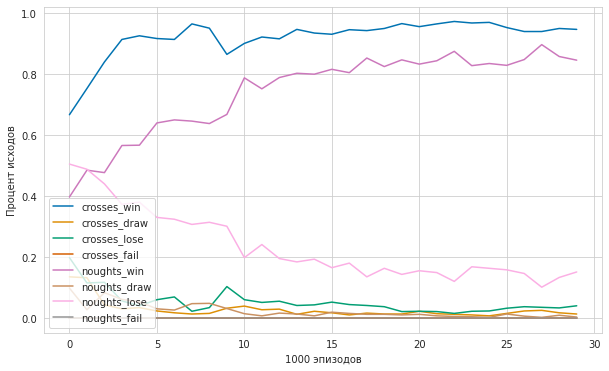

In [19]:
show_results(crosses, noughts)
plt.show()

#### 4x4

In [20]:
learner_4_4_4 = TicTacToeDQN(4, 4, 4, Network_4_4)
crosses, noughts = learn_to_play(learner_4_4_4, 100000, 1000)

100%|██████████| 100000/100000 [1:55:16<00:00, 14.46it/s]  


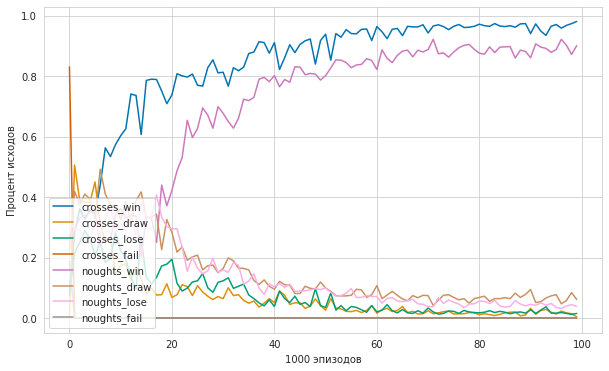

In [21]:
show_results(crosses, noughts)
plt.show()

### Реализуйте Double DQN и/или Dueling DQN.

#### Double DQN

In [22]:
class TicTacToeDoubleDQN(TicTacToeDQN):
    def __init__(
        self,
        n_rows=4,
        n_cols=4,
        n_win=4,
        model_class=Network_4_4,
        gamma=0.8,
        device=device,
    ):
        super(TicTacToeDoubleDQN, self).__init__(
            n_rows=n_rows,
            n_cols=n_cols,
            n_win=n_win,
            model_class=model_class,
            gamma=gamma,
            device=device,
        )
        self.target_models = {-1: model_class().to(device), 1: model_class().to(device)}
        self.episodes_learned = {-1: 0, 1: 0}

    def learn(self, cur_turn):
        if (
            np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])])
            < self.batch_size
        ):
            return

        # берём мини-батч из памяти
        transitions = self.memories[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))

        # считаем значения функции Q
        Q = self.models[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.target_models[cur_turn](batch_next_state).detach()
        Qmax = Qmax.max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizers[cur_turn].zero_grad()
        loss.backward()

        self.optimizers[cur_turn].step()

        self.episodes_learned[cur_turn] += 1
        if self.episodes_learned[cur_turn] % 500:
            self.target_models[cur_turn].load_state_dict(
                self.models[cur_turn].state_dict()
            )

#### 3x3

In [23]:
double_learner_3_3 = TicTacToeDoubleDQN(3, 3, 3, Network_3_3)
crosses, noughts = learn_to_play(double_learner_3_3, 30000, 1000)

100%|██████████| 30000/30000 [16:32<00:00, 30.24it/s]  


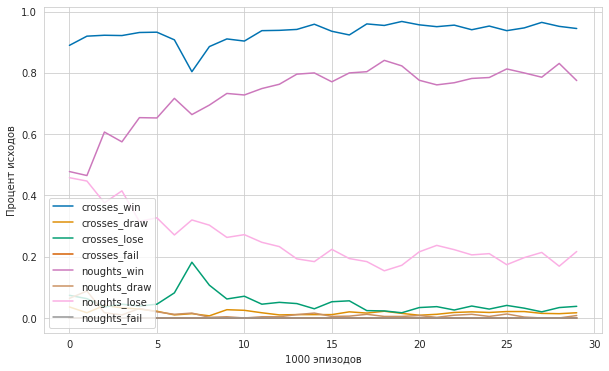

In [24]:
show_results(crosses, noughts)
plt.show()

#### 4x4

In [25]:
double_learner_4_4 = TicTacToeDoubleDQN(4, 4, 4, Network_4_4)
crosses, noughts = learn_to_play(double_learner_4_4, 100000, 1000)

100%|██████████| 100000/100000 [1:55:47<00:00, 14.39it/s]  


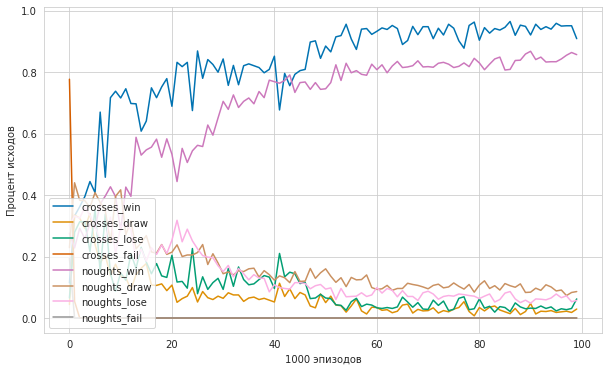

In [26]:
show_results(crosses, noughts)
plt.show()

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

Используем Q-Learning из (1) для обучения стратегий, сильно недоучим стратегии, чтобы посмотреть насколько помогают rollouts

In [27]:
pi_1 = Strategy()
pi_2 = Strategy()

env = TicTacToe(4, 4, 4)
total_episodes = 50000  # 1000000
test_episodes = 1000
idxs = []
crosses = []
noughts = []

for i in tqdm.tqdm(range(1, total_episodes + 1)):
    Q_learning_episode(env, pi_1, pi_2, epsilon=0.3, alpha=0.009)
    if i % test_episodes == 0:
        cross = test_policy(env, pi_1=pi_1, pi_2=None, num_episodes=500)
        nought = -test_policy(env, pi_1=None, pi_2=pi_2, num_episodes=500)
        idxs.append(i)
        crosses.append(cross)
        noughts.append(nought)
idxs = np.array(idxs)
crosses = np.array(crosses)
noughts = np.array(noughts)

result = np.vstack((idxs, crosses, noughts))

100%|██████████| 50000/50000 [02:58<00:00, 280.42it/s]


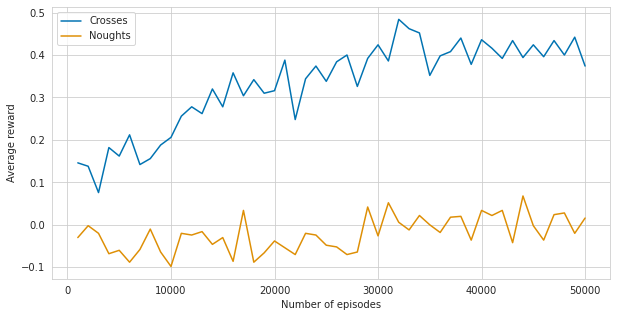

In [28]:
plot_results(result)
plt.show()

Теперь будем играть с использованием rollouts. Сразу сделаем вариант, где роллауты делаются по неслучайной стратегии для агента, а среда отвечает случайно. То есть если агент играет за крестики, то роллауты играются по его стратегии за крестики против случайных ноликов.

In [29]:
import copy


def make_rollouts(env, action, pi_1=None, pi_2=None, n_rollouts=100):
    rewards = []
    for i in range(n_rollouts):
        env_r = copy.deepcopy(env)
        state, reward, done, _ = env_r.step(action)
        board_hash, emptySpaces, curTurn = state
        while not done:
            if curTurn == 1:  # Ходят крестики
                if pi_1 is not None and board_hash in pi_1.Q:
                    idx = np.argmax(pi_1.Q[board_hash])
                else:
                    idx = np.random.randint(len(emptySpaces))
                a = emptySpaces[idx]
                state, reward, done, _ = env_r.step(a)
                board_hash_prime, emptySpaces_prime, curTurn_prime = state
            elif curTurn == -1:  # Ходят нолики
                if pi_2 is not None and board_hash in pi_2.Q:
                    idx = np.argmax(pi_2.Q[board_hash])
                else:
                    idx = np.random.randint(len(emptySpaces))
                a = emptySpaces[idx]
                state, reward, done, _ = env_r.step(a)
                board_hash_prime, emptySpaces_prime, curTurn_prime = state
            else:
                raise Exception("There is only 2 players!")

            board_hash, emptySpaces, curTurn = (
                board_hash_prime,
                emptySpaces_prime,
                curTurn_prime,
            )
        rewards.append(reward)
    return np.array(rewards).mean()

In [30]:
def play_test_game_with_rollouts(env, pi_1=None, pi_2=None):
    env.reset()
    board_hash, emptySpaces, curTurn = env.getState()
    reward = 0
    done = False
    while not done:
        if curTurn == 1:  # Ходят крестики
            if pi_1 is not None:  # Играем за крестики - делаем rollouts
                best_reward = -10
                idx = 0
                for i, action in enumerate(emptySpaces):
                    avg_reward = make_rollouts(env, action, pi_1=pi_1, n_rollouts=100)
                    if avg_reward > best_reward:
                        best_reward = avg_reward
                        idx = i
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
        elif curTurn == -1:  # Ходят нолики
            if pi_2 is not None:  # Играем за нолики - делаем rollouts
                best_reward = -10
                idx = 0
                for i, action in enumerate(emptySpaces):
                    avg_reward = -make_rollouts(env, action, pi_2=pi_2, n_rollouts=100)
                    if avg_reward > best_reward:
                        best_reward = avg_reward
                        idx = i
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            state, reward, done, _ = env.step(a)
            board_hash_prime, emptySpaces_prime, curTurn_prime = state
        else:
            raise Exception("There is only 2 players!")

        board_hash, emptySpaces, curTurn = (
            board_hash_prime,
            emptySpaces_prime,
            curTurn_prime,
        )
    return reward

In [31]:
n_games = 100
rewards = []
for _ in tqdm.tqdm(range(n_games)):
    reward = play_test_game_with_rollouts(env, pi_1=pi_1)
    rewards.append(reward)
print(f"Average reward for crosses: {np.mean(rewards):0.4f}")

n_games = 100
rewards = []
for _ in tqdm.tqdm(range(n_games)):
    reward = play_test_game_with_rollouts(env, pi_2=pi_2)
    rewards.append(reward)
print(f"Average reward for noughts: {-np.mean(rewards):0.4f}")

100%|██████████| 100/100 [11:18<00:00,  6.78s/it]


Average reward for crosses: 0.9800


100%|██████████| 100/100 [10:03<00:00,  6.04s/it]

Average reward for noughts: 0.9200


### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [32]:
class Node:
    def __init__(self, action, state, parent, layer):
        self.action = action
        self.board_hash = state[0]
        self.empty_spaces = state[1]
        self.turn = state[2]
        self.parent = parent
        self.children = dict()
        self.n = 0
        self.w = 0
        self.layer = layer

    @property
    def unvisited(self):
        return self.n == 0

    def __str__(self):
        return f'{self.layer * "--"}{self.board_hash} turn: {self.turn}, w: {self.w}, n: {self.n}, {self.parent.board_hash if self.parent else "ROOT"}'


class MCTS:
    def __init__(self, env, player=1, c=0.5):
        self.env = env
        self.env.reset()
        self.root = Node(None, self.env.getState(), None, 0)
        self.c = c
        self.player = player

    def print_all(self):
        print("----------")
        self._print_node(self.root)
        print("----------")

    def _print_node(self, node):
        print(node)
        for action, node in node.children.items():
            self._print_node(node)

    def learn_episode(self):
        done = False
        self.env.reset()
        state = self.env.getState()
        node = self.root
        while not done:
            if (
                node.unvisited
            ):  # Попали в ноду, которую до этого не посещали, значит пора делать rollout (по случайным стратегиям)
                while not done:
                    empty_spaces = self.env.getState()[1]
                    a = random.choice(empty_spaces)
                    state, reward, done, _ = self.env.step(a)
                break
            # Selection - выбираем куда идти
            if state[2] == self.player:
                if len(node.children) < len(
                    node.empty_spaces
                ):  # Есть еще не исследованные варианты - выбираем первое из неисследованных
                    for action in node.empty_spaces:
                        action_int = self.env.int_from_action(action)
                        if action_int not in node.children.keys():
                            a = action
                            break
                else:  # все варианты уже пробовали - выбираем по UCT
                    best_value = 0
                    values = []
                    for action in node.empty_spaces:
                        action_int = self.env.int_from_action(action)
                        exploitation = (
                            node.children[action_int].w / node.children[action_int].n
                        )
                        exploration = np.sqrt(
                            np.log(node.n) / node.children[action_int].n
                        )
                        values.append(
                            (node.children[action_int].n, exploitation, exploration)
                        )
                        value = exploitation + self.c * exploration
                        if value > best_value:
                            best_value = value
                            a = action
            else:  # Выбираем случайно
                empty_spaces = self.env.getState()[1]
                a = random.choice(empty_spaces)
            state, reward, done, _ = self.env.step(a)
            a_int = self.env.int_from_action(a)
            if a_int in node.children:
                # Движемся по известной траектории
                node = node.children[a_int]
            else:
                # Expansion
                next_node = Node(
                    action=a, state=state, parent=node, layer=node.layer + 1
                )
                node.children[a_int] = next_node
                node = next_node

        if reward == -10:
            raise Exception("Wrong turn!")
        # Backprop
        while node.parent:
            node.n += 1
            if node.turn == -reward:
                node.w += 1
            node = node.parent
        node.n += 1
        if node.turn == -reward:
            node.w += 1

    def rollout(self):
        done = False
        _, empty_spaces, _ = self.env.getState()
        while not done:
            a = random.choice(empty_spaces)
            state, reward, done, _ = self.env.step(a)
            _, empty_spaces, _ = state
        return reward

    def test_game(self):
        positions = []
        self.env.reset()
        node = self.root
        board_hash, empty_spaces, turn = self.env.getState()
        done = False
        while not done:
            positions.append(board_hash)
            if turn == self.player:  # ход агента
                if (
                    len(node.children) < len(empty_spaces) or len(node.children) == 0
                ):  # Rollout, т.к. совсем мало знаем
                    return self.rollout(), positions
                # Ищем по существующему дереву
                best_value = -1.0
                for action_int in node.children.keys():
                    action = self.env.action_from_int(action_int)
                    value = node.children[action_int].w / node.children[action_int].n
                    if value > best_value:
                        best_value = value
                        a = action
            else:  # случайный ход
                a = random.choice(empty_spaces)
            state, reward, done, _ = self.env.step(a)
            if not done:  # Если не закончили - готовимся к след действию
                board_hash, empty_spaces, turn = state
                a_int = self.env.int_from_action(a)
                if a_int in node.children:
                    node = node.children[a_int]
                else:
                    return self.rollout(), positions
        return reward, positions

#### 3x3

In [33]:
env = TicTacToe(3, 3, 3)
tree = MCTS(env, player=1, c=1.0)

crosses_win = []
crosses_draw = []
crosses_lose = []
crosses_fail = []
rewards = {-1: 0, 0: 0, 1: 0}
for i in tqdm.tqdm(range(50_000)):
    tree.learn_episode()
    if (i + 1) % 1_000 == 0:
        rewards = {-1: 0, 0: 0, 1: 0}
        for _ in range(1000):
            reward, positions = tree.test_game()
            rewards[reward] += 1
        crosses_win.append(rewards[1] / 1000)
        crosses_draw.append(rewards[0] / 1000)
        crosses_lose.append(rewards[-1] / 1000)
        crosses_fail.append(0)
crosses = (crosses_win, crosses_draw, crosses_lose, crosses_fail)

100%|██████████| 50000/50000 [00:59<00:00, 842.02it/s] 


In [34]:
env = TicTacToe(3, 3, 3)
tree = MCTS(env, player=-1, c=1.0)

noughts_win = []
noughts_draw = []
noughts_lose = []
noughts_fail = []
for i in tqdm.tqdm(range(50_000)):
    tree.learn_episode()
    if (i + 1) % 1_000 == 0:
        rewards = {-1: 0, 0: 0, 1: 0}
        for _ in range(1000):
            reward, positions = tree.test_game()
            rewards[reward] += 1
        noughts_win.append(rewards[-1] / 1000)
        noughts_draw.append(rewards[0] / 1000)
        noughts_lose.append(rewards[1] / 1000)
        noughts_fail.append(0)
noughts = (noughts_win, noughts_draw, noughts_lose, noughts_fail)

100%|██████████| 50000/50000 [01:06<00:00, 752.15it/s] 


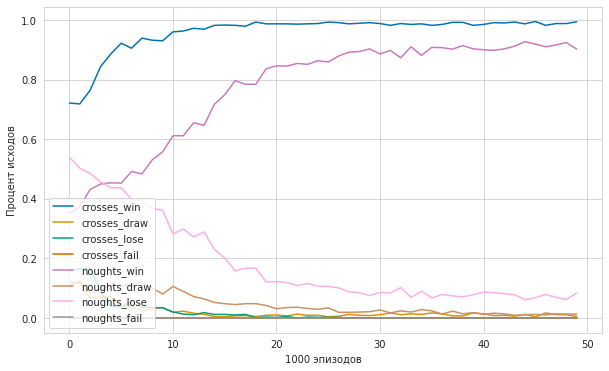

In [35]:
show_results(crosses, noughts, period=1000)
plt.show()